### GMM with early stopping

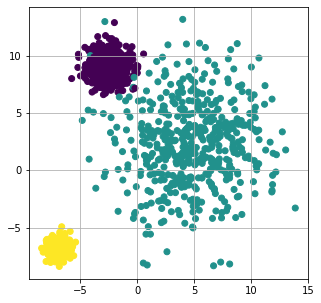

In [1]:
from scipy.stats import multivariate_normal
from sklearn.datasets import make_blobs
from sklearn import datasets
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time

n_samples = 1500

X, y = make_blobs(n_samples=1500, cluster_std=[1.0, 3.5, 0.5], random_state=42)

# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train,y_test = train_test_split(X,y,test_size=0.3, shuffle=True, random_state=42)


figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

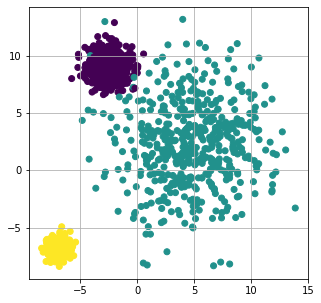

In [2]:

figure = plt.figure(figsize=(5, 5))
ax = plt.axes()  #get the instance of axes from plt

ax.grid()
ax.scatter(X[:, 0], X[:, 1], c=y)

#### Initialization

In [3]:
# #responsibliity
# r = np.full(shape=(m, K), fill_value=1/K)

# #pi
# pi = np.full((K, ), fill_value=1/K) #simply use 1/k for pi

# #mean
# random_row = np.random.randint(low=0, high=m, size=K)
# mean = np.array([X[idx,:] for idx in random_row ]).T #.T to make to shape (M, K)

# #covariance
# cov = np.array([np.cov(X.T) for _ in range (K)])


In [48]:
#define basic params
m, n = X.shape
# K = 3
# max_iter = 20
oldNLL = 0

In [78]:
NLLs = []
Ks = 5

class GMM:
    def __init__(self,K,max_iter=20):
        self.K = K
        self.max_iter = max_iter
    
    def fit(self,X):
        self.m = X.shape[0]
        self.n = X.shape[1]
        #responsibliity
        self.r = np.full(shape=(self.m, self.K), fill_value=1/self.K)
        
        #pi
        self.pi = np.full((self.K, ), fill_value=1/self.K) #simply use 1/k for pi
    
        #mean
        self.random_row = np.random.randint(low=0, high = self.m , size=self.K)
        self.mean = np.array([X[idx,:] for idx in self.random_row ]).T #.T to make to shape (M, K)
    
        #covariance
        self.cov = np.array([np.cov(X.T) for _ in range (self.K)])
        self.oldNLL = 0
        
        for iteration in range(self.max_iter + 1):
            #===E-Step=====
            #Update r_ik of each sample
            for i in range(self.m):
                for k in range(self.K):
                    xi_pdf = multivariate_normal.pdf(X[i], mean=self.mean[:, k], cov=self.cov[k])
                    self.r[i, k] = self.pi[k] * xi_pdf
                self.r[i] /= np.sum(self.r[i])


            self.NLL = 0
            for i in range(self.m):
                for k in range(self.K):
                    self.NLL += math.log(self.pi[k])
                    self.NLL += multivariate_normal.logpdf( X[i], mean = self.mean[:, k], cov = self.cov[k])
    #                 self.NLL = self.NLL #/self.K

            #every 5 iteration plot once
            if(iteration % 10 == 0):
                preds = self.predict(X)
                plt.figure()
                plt.scatter(X[:, 0], X[:, 1], c=preds)
                plt.title(f"Iteration: {iteration}")
                print("NLL smaller? ", self.NLL)
                print("NLL difference: ", math.fabs(self.NLL - self.oldNLL))

            if(math.fabs(self.NLL-self.oldNLL) < 5):
                print("Final NLL: ", self.NLL)
                print("final difference: ", math.fabs(self.NLL - self.oldNLL))
                break
    #             self.NLL = NLL
            self.oldNLL = self.NLL

            #===M-Step====
            # Find NK first for latter use
            NK = np.sum(self.r, axis=0)
            assert NK.shape == (self.K, )

            #PI
            self.pi = NK / self.m
            assert self.pi.shape == (self.K, )

            #mean
            self.mean =  ( X.T @ self.r ) / NK
            assert self.mean.shape == (self.n, self.K)

            #covariance (also called Sigma)
            for k in range(self.K):
                for i in range(self.m):
                    X_mean = (X[i]-self.mean[:, k]).reshape(-1, 1)
                    self.cov[k] += self.r[i, k] * (X_mean @ X_mean.T)
                self.cov[k] /= NK[k]
            assert self.cov.shape == (self.K, self.n, self.n)

    def predict(self,X):
#         plt.figure()
#         plt.scatter(X[:, 0], X[:, 1], c=preds)
#         print("NLL smaller? ", self.NLL)
#         print("NLL difference: ", math.fabs(self.NLL - self.oldNLL))
#         print(self.r)
        return np.argmax(self.r, axis=1)

        

====== k = 2 ======
NLL smaller?  -23479.420038339376
NLL difference:  23479.420038339376
NLL smaller?  -88865.31538512638
NLL difference:  4367.919803104378
NLL smaller?  -109330.77576477251
NLL difference:  530.5998490381608
Fit and predict time 17.902480840682983
====== k = 3 ======
NLL smaller?  -37386.33604077738
NLL difference:  37386.33604077738
NLL smaller?  -201519.49598604426
NLL difference:  4499.65319133157
NLL smaller?  -641487.8619276157
NLL difference:  117318.67564922973
Fit and predict time 26.453094959259033
====== k = 4 ======
NLL smaller?  -51194.28293741968
NLL difference:  51194.28293741968
NLL smaller?  -658583.177363274
NLL difference:  114.98593602434266
NLL smaller?  -659610.2427021618
NLL difference:  76.33780980226584
Fit and predict time 35.09431862831116
====== k = 5 ======
NLL smaller?  -67138.44014491202
NLL difference:  67138.44014491202
NLL smaller?  -797653.6557895383
NLL difference:  1606.5349320047535
NLL smaller?  -790269.5582464845
NLL difference:

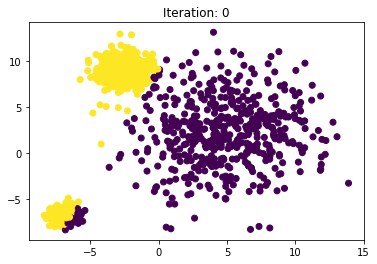

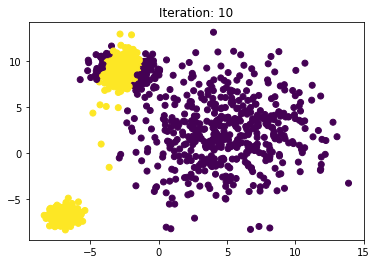

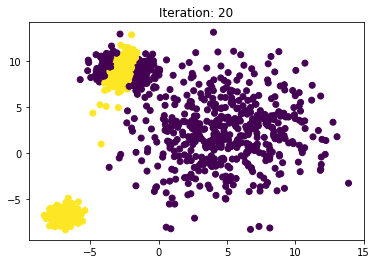

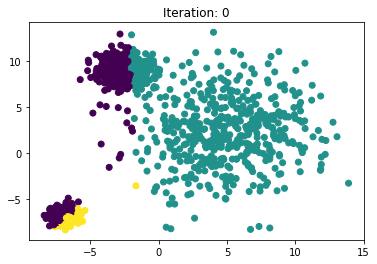

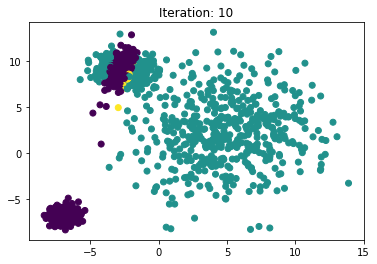

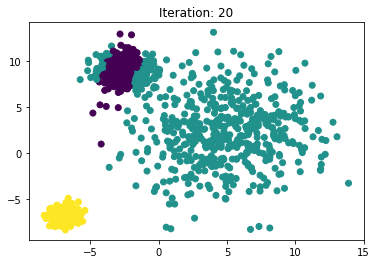

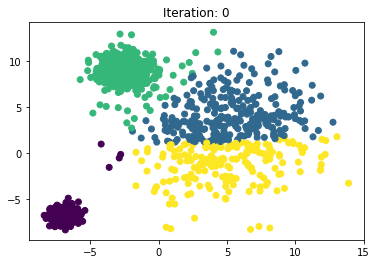

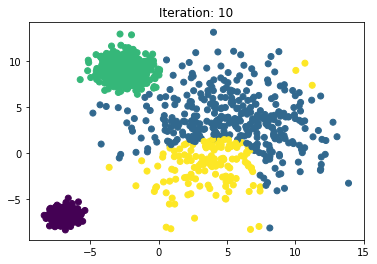

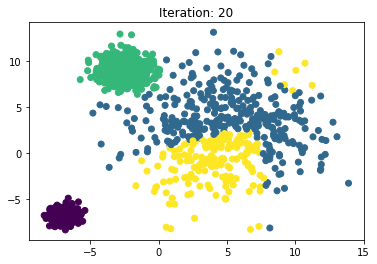

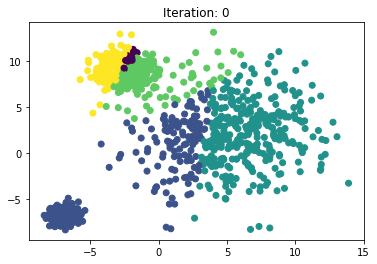

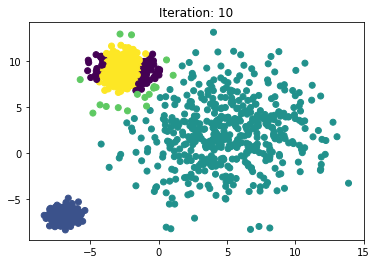

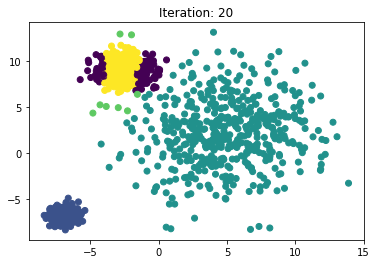

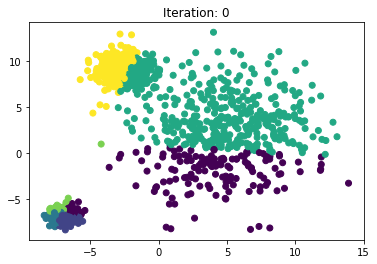

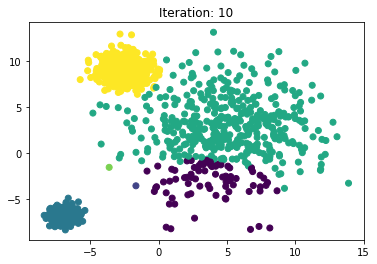

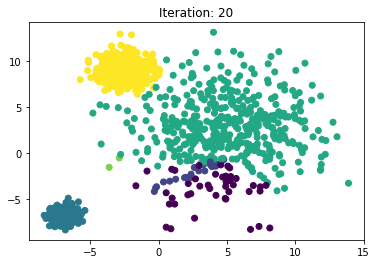

In [79]:
#main code
NLLs = []
for k in range(2,7):
    print(f"====== k = {k} ======")
    start = time()
    model = GMM(k)
    model.fit(X)
    NLLs.append(model.NLL)
    preds = model.predict(X)
    print(f"Fit and predict time {time() - start}")

[-109330.77576477251, -641487.8619276157, -659610.2427021618, -790269.5582464845, -1063599.7555725973]


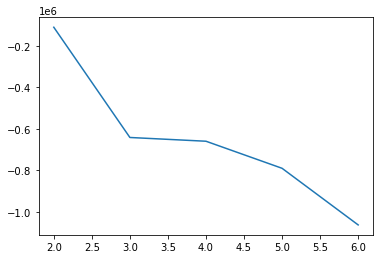

In [80]:
k = np.arange(2,7)
print(NLLs)
plt.plot(k,NLLs)

### Chosen k = 3

NLL smaller?  -35905.50632114
NLL difference:  35905.50632114
NLL smaller?  -127811.7667634581
NLL difference:  12693.83694167831
NLL smaller?  -639499.5709432227
NLL difference:  194.25248008349445


Text(0.5, 1.0, 'Final')

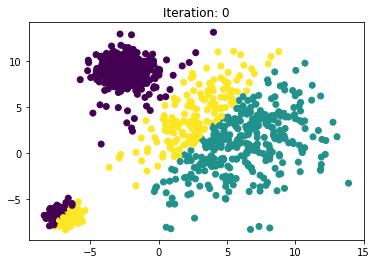

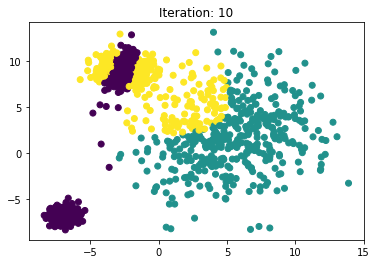

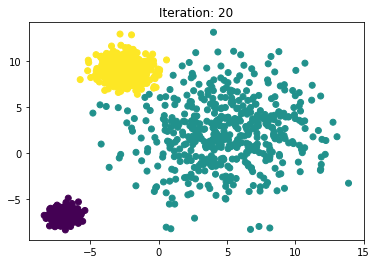

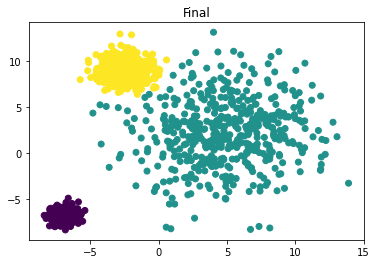

In [81]:
k = 3
model = GMM(k)
model.fit(X)
yhat = model.predict(X)

#plot
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=yhat)
plt.title("Final")

#Plotting from matt

In [ ]:
# # Re-run k-means with k=3

# k = 2
# means = init_kmeans(X, k)
# prev_distortion = 0
# while True:
#     means, c, distortion = iterate_kmeans(X, means)
#     if prev_distortion > 0 and prev_distortion - distortion < epsilon:
#         break
#     prev_distortion = distortion
    
# # Set labels in dataset to cluster IDs according to k-means model.

# label = c

# idx_correct = (label == 0) == (y == 0)
# idx_correct_0 = ((label == 0) & idx_correct).reshape(400)
# idx_correct_1 = ((label == 1) & idx_correct).reshape(400)
# idx_incorrect_0 = ((label == 0) & ~idx_correct).reshape(400)
# idx_incorrect_1 = ((label == 1) & ~idx_correct).reshape(400)

# # Plot the data

# fig = plt.figure(figsize=(10,10))
# # ax = fig.add_subplot(111, projection='2d')
# plt.plot(X[idx_correct_0, 0], X[idx_correct_0, 1], 'ro', label='Class 0 correct')
# plt.plot(X[idx_correct_1, 0], X[idx_correct_1, 1], 'bo', label='Class 1 correct')
# plt.plot(X[idx_incorrect_0, 0], X[idx_incorrect_0, 1], 'r*', label='Class 0 incorrect', ms=20)
# plt.plot(X[idx_incorrect_1, 0], X[idx_incorrect_1, 1], 'b*', label='Class 1 incorrect', ms=20)
# # ax.scatter(df.Age[df.label == 1], df["Annual Income (k$)"][df.label == 1], df["Spending Score (1-100)"][df.label == 1], c='red', s=60)
# # ax.scatter(df.Age[df.label == 2], df["Annual Income (k$)"][df.label == 2], df["Spending Score (1-100)"][df.label == 2], c='green', s=60)

# # For 5 clusters, you can uncomment the following two lines.

# #ax.scatter(df.Age[df.label == 3], df["Annual Income (k$)"][df.label == 3], df["Spending Score (1-100)"][df.label == 3], c='orange', s=60)
# #ax.scatter(df.Age[df.label == 4], df["Annual Income (k$)"][df.label == 4], df["Spending Score (1-100)"][df.label == 4], c='purple', s=60)

# ax.view_init(0, 45)
# plt.xlabel("Age")
# plt.ylabel("Annual Income (k$)")
# ax.set_zlabel('Spending Score (1-100)')
# plt.title('Customer segments (k=3)')
# plt.show()